In [2]:
# This is the Analysis section of the project. This section will consist of 
# exploratory data analysis (EDA) and visualization of the datasets used in the project.
# These visualizations will help to understand the data and provide insights that may be useful for 
# future analysis and training of ML models.ipynb

# Sources:
# Disclaimer: GenAI was used for idea generation, suggestions, and debugging but not for full code generation.

In [3]:
# Imports
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import subplots
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from skbio.diversity.alpha import shannon, simpson
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier


In [4]:
# Import datasets with pandas
filepath = os.getcwd() + "/datasets"
dataset_4_1 = pd.read_csv(os.path.join(filepath, "4.1_final_assignments.csv"))
dataset_4_2 = pd.read_csv(os.path.join(filepath, "4.2_final_assignments.csv"))
dataset_4_3 = pd.read_csv(os.path.join(filepath, "4.3_final_assignments.csv"))
dataset_4_4 = pd.read_csv(os.path.join(filepath, "4.4_final_assignments.csv"))
dataset_4_5 = pd.read_csv(os.path.join(filepath, "4.5_final_assignments.csv"))
dataset_8_1 = pd.read_csv(os.path.join(filepath, "8.1_final_assignments.csv"))
dataset_8_2 = pd.read_csv(os.path.join(filepath, "8.2_final_assignments.csv"))
dataset_8_3 = pd.read_csv(os.path.join(filepath, "8.3_final_assignments.csv"))
dataset_8_4 = pd.read_csv(os.path.join(filepath, "8.4_final_assignments.csv"))
dataset_8_5 = pd.read_csv(os.path.join(filepath, "8.5_final_assignments.csv"))

In [5]:
# Combine Datasets into one set for visualization and analysis
combined_dataset = pd.concat([dataset_4_1, dataset_4_2, dataset_4_3, dataset_4_4, dataset_4_5, dataset_8_1, 
                              dataset_8_2, dataset_8_3, dataset_8_4, dataset_8_5], ignore_index=True)

# Drop any fully duplicated rows
combined_dataset.drop_duplicates(inplace=True)

# Drop rows where critical values are missing (essentially dropNA on key columns)
critical_cols = ['wwtp', 'wrf', 'GenomeName', 'Proteins', 'network']
combined_dataset.dropna(subset=critical_cols, inplace=True)

# Convert time and pore size collumns to appropriate data types
combined_dataset['collection.date'] = pd.to_datetime(combined_dataset['collection.date'], errors='ignore')
combined_dataset['pore.size.um'] = combined_dataset['pore.size'].str.extract(r'(\d+\.?\d*)').astype(float)
combined_dataset.drop('pore.size', axis=1, inplace=True)


# Standardize string columns and clean prediction columns
object_cols = combined_dataset.select_dtypes(include='object').columns.tolist()

for col in object_cols:
    combined_dataset[col] = combined_dataset[col].astype(str).str.lower()
    
    # Clean predictions (e.x 'taleaviricota|nan' -> 'taleaviricota')
    if 'prediction' in col:
        # Split by '|' and take the first element (the most likely prediction)
        combined_dataset[col] = combined_dataset[col].str.split('|').str[0]

# Fill nan Genome Size (Kb) with the median
median_size = combined_dataset['Size (Kb)'].median()
combined_dataset['Size (Kb)'].fillna(median_size, inplace=True)

# Fill remaining NaN values in object columns with 'unknown'
object_cols_for_filling = combined_dataset.select_dtypes(include='object').columns.tolist()
for col in object_cols_for_filling:
    combined_dataset[col].fillna('unknown', inplace=True)

# Generate CSV of combined dataset for future use
combined_dataset.to_csv(os.path.join(filepath, "combined_final_assignments.csv"), index=False)

C:\Users\apurv\AppData\Local\Temp\ipykernel_20608\2739461662.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  combined_dataset['collection.date'] = pd.to_datetime(combined_dataset['collection.date'], errors='ignore')
C:\Users\apurv\AppData\Local\Temp\ipykernel_20608\2739461662.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_dataset['collection.date'] = pd.to_datetime(combined_dataset['collection.date'], errors='ignore')
C:\Users\apurv\AppData\Local\Temp\ipykernel_20608\2739461662.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

## Exploratory Data Analysis (EDA)

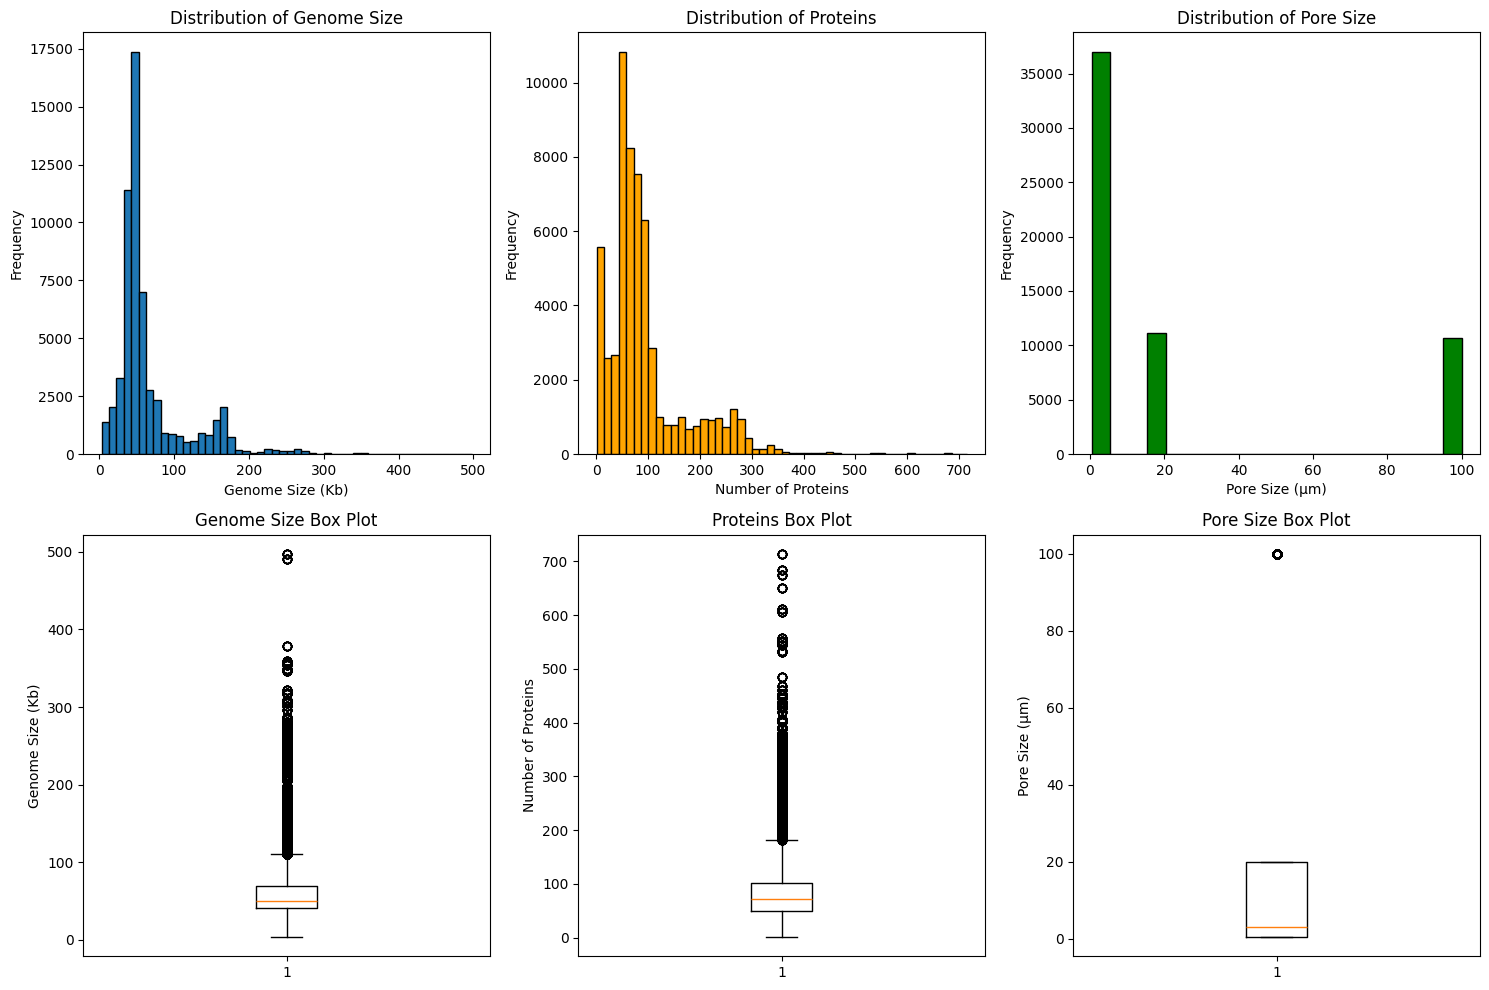

In [6]:
# Distribution of genome size, proteins, and pore size
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Genome size distribution
axes[0, 0].hist(combined_dataset['Size (Kb)'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Genome Size (Kb)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Genome Size')

# Proteins distribution
axes[0, 1].hist(combined_dataset['Proteins'], bins=50, edgecolor='black', color='orange')
axes[0, 1].set_xlabel('Number of Proteins')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Proteins')

# Pore Size distribution
axes[0, 2].hist(combined_dataset['pore.size.um'].dropna(), bins=20, edgecolor='black', color='green')
axes[0, 2].set_xlabel('Pore Size (μm)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Pore Size')

# box plots for outlier detection
axes[1, 0].boxplot(combined_dataset['Size (Kb)'].dropna())
axes[1, 0].set_ylabel('Genome Size (Kb)')
axes[1, 0].set_title('Genome Size Box Plot')

axes[1, 1].boxplot(combined_dataset['Proteins'].dropna())
axes[1, 1].set_ylabel('Number of Proteins')
axes[1, 1].set_title('Proteins Box Plot')

axes[1, 2].boxplot(combined_dataset['pore.size.um'].dropna())
axes[1, 2].set_ylabel('Pore Size (μm)')
axes[1, 2].set_title('Pore Size Box Plot')

plt.tight_layout()
plt.show()

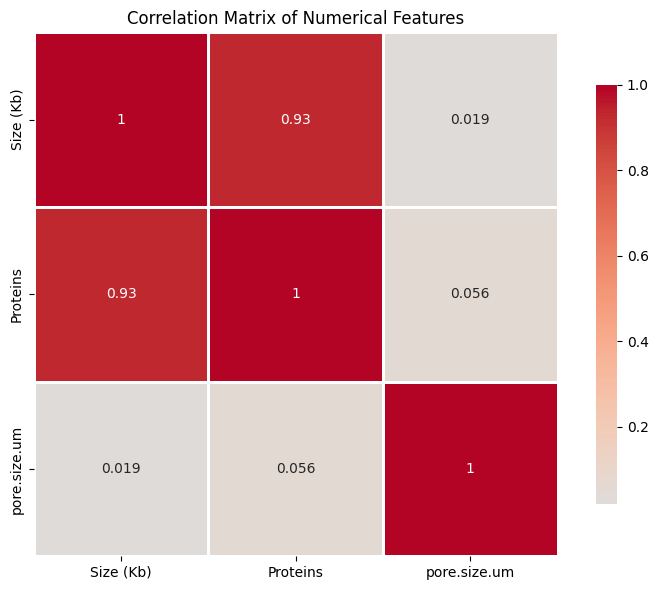

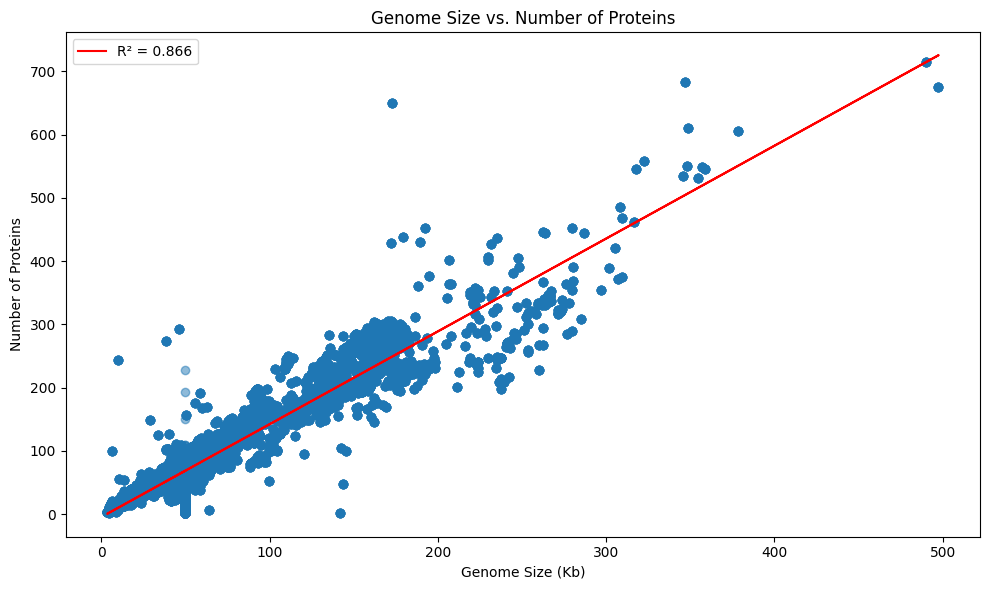

In [7]:
# Correlation matrix only for numerical features
numerical_cols = ['Size (Kb)', 'Proteins', 'pore.size.um']
correlation_matrix = combined_dataset[numerical_cols].corr()

# Plotting a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Scatter plot for genome size vs proteins
plt.figure(figsize=(10, 6))
plt.scatter(combined_dataset['Size (Kb)'], combined_dataset['Proteins'], alpha=0.5)
plt.xlabel('Genome Size (Kb)')
plt.ylabel('Number of Proteins')
plt.title('Genome Size vs. Number of Proteins')

# linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    combined_dataset['Size (Kb)'].dropna(), 
    combined_dataset['Proteins'].dropna()
)
line = slope * combined_dataset['Size (Kb)'] + intercept
plt.plot(combined_dataset['Size (Kb)'], line, color='red', label=f'R² = {r_value**2:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:** Strong positive correlation (R^2 ~= 0.90) between genome size and protein count indicates that larger genomes consistently encode more proteins. The near-perfect linear relationship suggests genome size is a strong predictor of protein content.

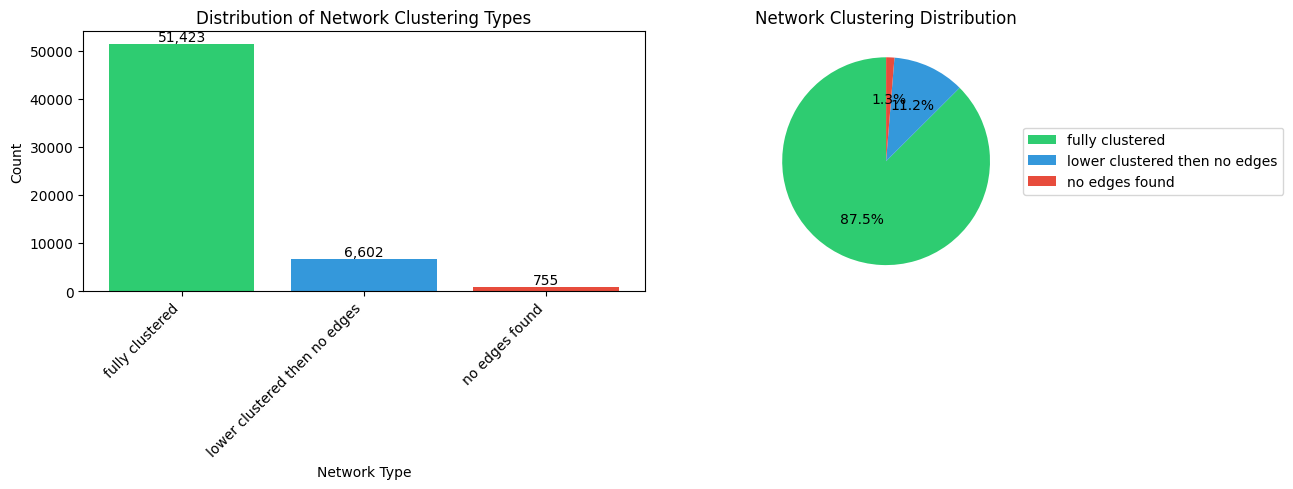

In [8]:
# Network clustering distribution
network_counts = combined_dataset['network'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart with counts
bars = axes[0].bar(range(len(network_counts)), network_counts.values, color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0].set_xticks(range(len(network_counts)))
axes[0].set_xticklabels(network_counts.index, rotation=45, ha='right')
axes[0].set_xlabel('Network Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Network Clustering Types')

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

# Pie chart with legend
colors_pie = ['#2ecc71', '#3498db', '#e74c3c']
axes[1].pie(network_counts.values, labels=None, autopct='%1.1f%%', 
           colors=colors_pie, startangle=90)
axes[1].set_title('Network Clustering Distribution')
axes[1].legend(network_counts.index, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

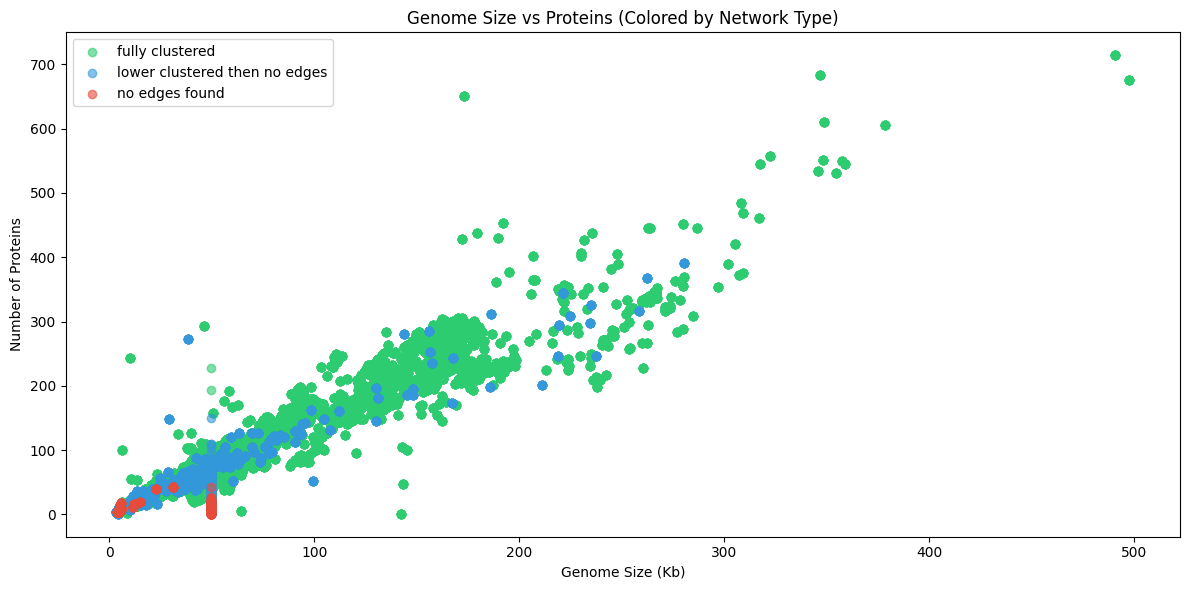

Correlation between Size and Proteins by Network Type:
  fully clustered: 0.952
  lower clustered then no edges: 0.810
  no edges found: -0.271


In [13]:
# Scatter plot colored by network type
network_types = combined_dataset['network'].unique()
colors_network = {'fully clustered': '#2ecc71', 
                  'lower clustered then no edges': '#3498db', 
                  'no edges found': '#e74c3c'}

plt.figure(figsize=(12, 6))
for network_type in network_types:
    mask = combined_dataset['network'] == network_type
    subset = combined_dataset[mask]
    plt.scatter(subset['Size (Kb)'], subset['Proteins'], 
               label=network_type, alpha=0.6, 
               color=colors_network.get(network_type, 'gray'))

plt.xlabel('Genome Size (Kb)')
plt.ylabel('Number of Proteins')
plt.title('Genome Size vs Proteins (Colored by Network Type)')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate correlation for each network type
print("Correlation between Size and Proteins by Network Type:")
for network_type in network_types:
    mask = combined_dataset['network'] == network_type
    subset = combined_dataset[mask]
    corr = subset[['Size (Kb)', 'Proteins']].corr().iloc[0, 1]
    print(f"  {network_type}: {corr:.3f}")

**Observation:** Fully clustered viruses show very strong correlation (0.952) between size and proteins. Notably, the "no edges found" group has a **negative correlation (-0.271)**, which is unusual and suggests these viruses may have atypical genome organization or represent misassemblies/novel viral types.

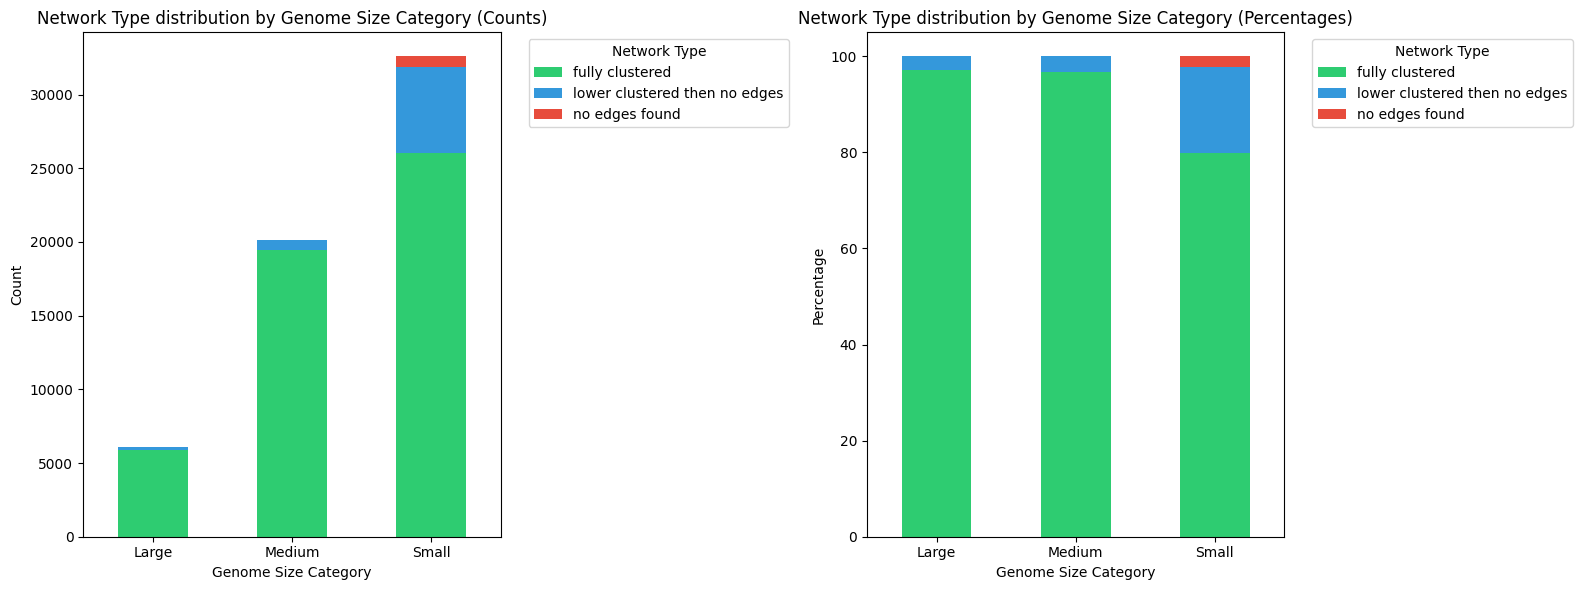

Network Type distribution by Genome Size Category (Percentages):
network          fully clustered  lower clustered then no edges  \
genome_category                                                   
Large                  97.105263                       2.894737   
Medium                 96.747887                       3.252113   
Small                  79.972384                      17.710954   

network          no edges found  
genome_category                  
Large                  0.000000  
Medium                 0.000000  
Small                  2.316662  


In [14]:
# Network type distribution across genome size categories
network_genome_crosstab = pd.crosstab(combined_dataset['genome_category'], 
                                      combined_dataset['network'])

# Calculate percentages
network_genome_pct = network_genome_crosstab.div(network_genome_crosstab.sum(axis=1), axis=0) * 100

# Stacked bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

network_genome_crosstab.plot(kind='bar', stacked=True, ax=axes[0], 
                             color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0].set_xlabel('Genome Size Category')
axes[0].set_ylabel('Count')
axes[0].set_title('Network Type distribution by Genome Size Category (Counts)')
axes[0].legend(title='Network Type', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

network_genome_pct.plot(kind='bar', stacked=True, ax=axes[1], 
                       color=['#2ecc71', '#3498db', '#e74c3c'])
axes[1].set_xlabel('Genome Size Category')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Network Type distribution by Genome Size Category (Percentages)')
axes[1].legend(title='Network Type', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("Network Type distribution by Genome Size Category (Percentages):")
print(network_genome_pct)

**Observation:** Genome size strongly affects clustering success. Large genomes (>150 Kb) are 97% fully clustered, while small genomes (<50 Kb) are only 80% fully clustered with 18% in "lower clustered then no edges." This suggests smaller viral genomes are harder to classify and may be more diverse or divergent.

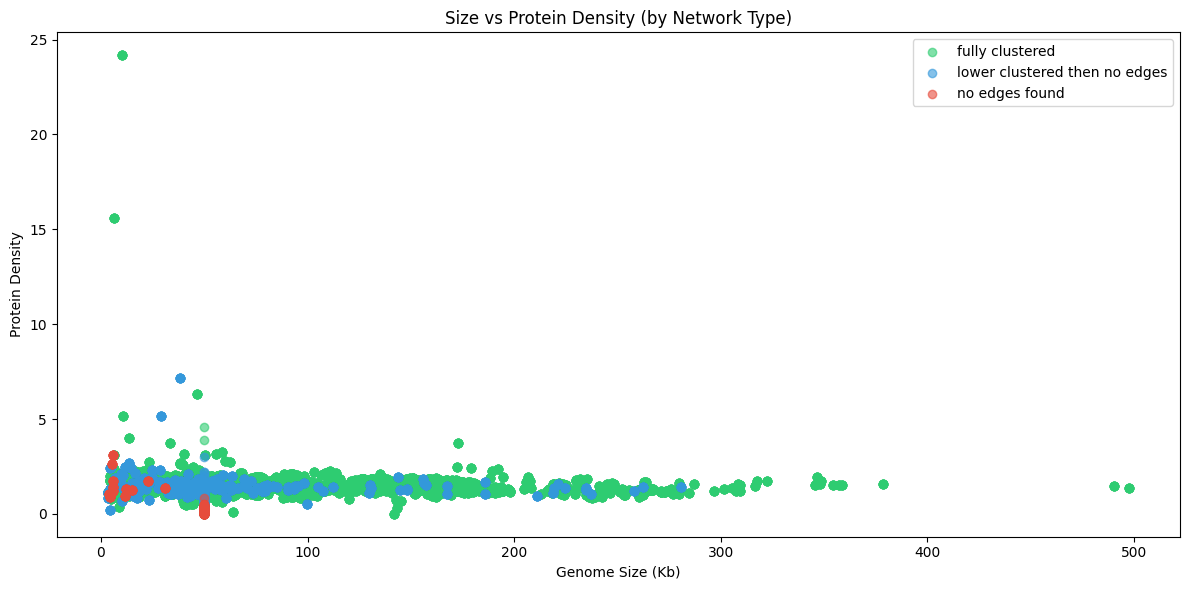

In [ ]:
# Size vs Protein Density grouped by network type
plt.figure(figsize=(12, 6))
for network_type in network_types:
    mask = combined_dataset['network'] == network_type
    subset = combined_dataset[mask]
    plt.scatter(subset['Size (Kb)'], subset['protein_density'], 
               label=network_type, alpha=0.6,
               color=colors_network.get(network_type, 'gray'))
plt.xlabel('Genome Size (Kb)')
plt.ylabel('Protein Density')
plt.title('Size vs Protein Density (by Network Type)')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:** Protein density (proteins/Kb) decreases as genome size increases, showing higher coding efficiency in smaller genomes. Most viruses cluster around 1-2 proteins/Kb. Outliers with very high protein density (>5 proteins/Kb) in small genomes may indicate annotation errors or unique compact genome architectures.

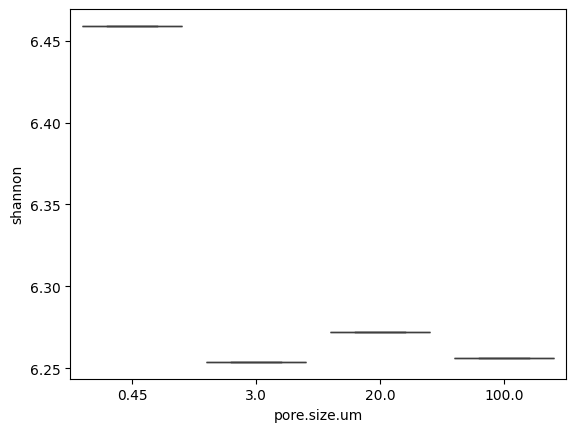

<Figure size 1200x800 with 0 Axes>

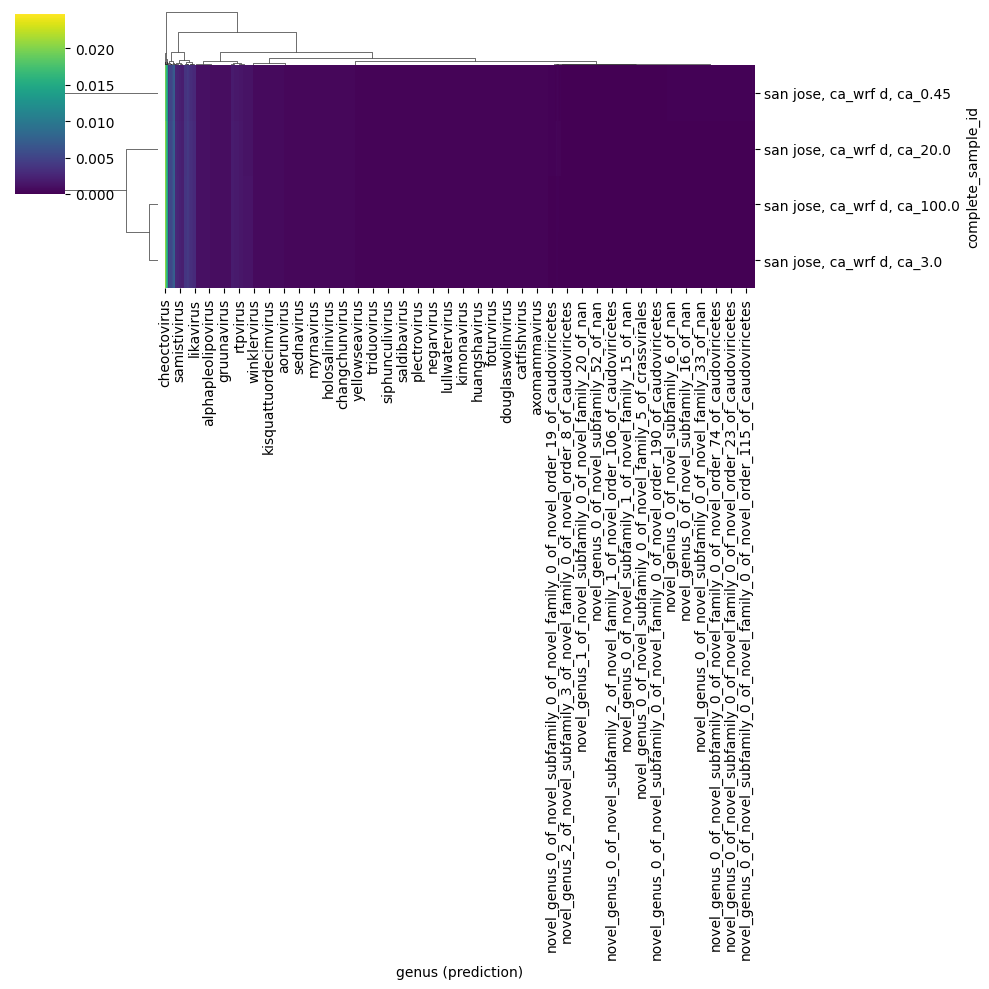

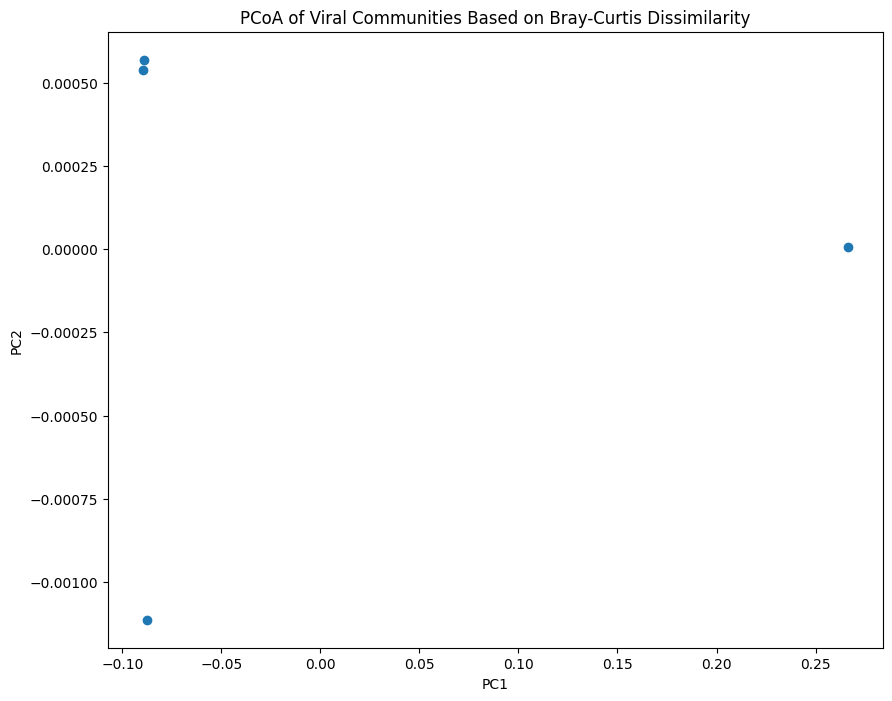

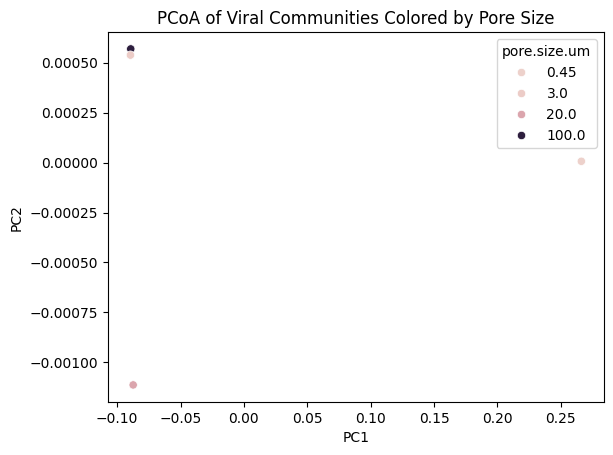

In [10]:
### Part 1 #################################################################################################################
# Notes left for clarity. This section is essentially guided EDA and visualization of viral diversity accross pore sizes
# for part 1 of our project tasking

# Viral Density Accross Pore Sizes 
df = pd.read_csv("datasets/combined_final_assignments.csv")

# Create individual sample identifiers
df['complete_sample_id'] = (
    df['wwtp'] + "_" +
    df['wrf'] + "_" +
    df['pore.size.um'].astype(str)
)

# Create a genus abundance table
genus_table = (
    df.groupby(['complete_sample_id', 'genus (prediction)'])
      .size()
      .reset_index(name='abundance')
      .pivot(index='complete_sample_id', columns='genus (prediction)', values='abundance')
      .fillna(0)
)


# evaluate the diversity by metrics such as alpha diversity and beta diversity, PCoA clusters, heatmaps (From our assignmetn instructions)
# Alpha diversity is calculated using Shannon index, Simpson index, and richness (the number of unique genera)
# calc alpha diversity metrics
alpha_df = pd.DataFrame({
    'sample_id': genus_table.index,
    'shannon': genus_table.apply(shannon, axis=1),
    'simpson': genus_table.apply(simpson, axis=1),
    'richness': (genus_table > 0).sum(axis=1)
})

# merge metadata back into alpha diversity dataframe
alpha_df = alpha_df.merge(
    df[['complete_sample_id', 'pore.size.um', 'wwtp', 'wrf']].drop_duplicates(),
    on='complete_sample_id',
    how='left'
)

# Plot Shannon Diversity relating to pore sizes
sns.boxplot(data=alpha_df, x='pore.size.um', y='shannon')
plt.show()

# Headmap of genus abundance
plt.figure(figsize=(12,8))
sns.clustermap(genus_table.apply(lambda x: x / x.sum(), axis=1),
               cmap='viridis',
               metric='euclidean',
               method='ward')
plt.show()

# Beta Diversity
# Beta diversity is a measure of the difference in diversity between samples. Uses Bray-Curtis dissimilarity 
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
bray_curtis_dm = beta_diversity(
    metric='braycurtis',
    counts=genus_table.values,
    ids=genus_table.index
)
pcoa_results = pcoa(bray_curtis_dm)

# Plot PCoA results
plt.figure(figsize=(10,8))
plt.scatter(pcoa_results.samples['PC1'], pcoa_results.samples['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCoA of Viral Communities Based on Bray-Curtis Dissimilarity')
plt.show()

# PCoA Clusters
sns.scatterplot(
    data=pcoa_results.samples,
    x='PC1',
    y='PC2',
    hue=alpha_df.set_index('complete_sample_id').loc[pcoa_results.samples.index]['pore.size.um']
)
plt.title('PCoA of Viral Communities Colored by Pore Size')
plt.show()

In [11]:
# Application of ML methods to predict viral taxonomy from genome level features 

features = df[['Size (Kb)', 'Proteins', 'pore.size.um', 'wwtp', 'wrf', 'season', 'network']]
target_family = df['family (prediction)']
target_genus  = df['genus (prediction)']

# remove rows where the target is missing
valid_idx = target_family.notna()
features = features.loc[valid_idx]
target_family = target_family.loc[valid_idx]
target_genus = target_genus.loc[valid_idx]

## Replace any newly introduce NAN values from one-hot encoding
# Fill NaN values in categorical features with 'unknown' (One-hot encoding can not handle NaN values)
features[['wwtp','wrf','season','network']] = (
    features[['wwtp','wrf','season','network']].fillna('unknown')
)

# fill missing numerical values with median
features['Size (Kb)'] = features['Size (Kb)'].fillna(features['Size (Kb)'].median())
features['Proteins'] = features['Proteins'].fillna(features['Proteins'].median())
features['pore.size.um'] = features['pore.size.um'].fillna(features['pore.size.um'].median())

# fill missing categorical values with 'unknown'
features[['wwtp','wrf','season','network']] = (
    features[['wwtp','wrf','season','network']].fillna('unknown')
)

# use one-hot encoding for catagorical variables
# one-hot encoding converts categorial vars into elements of 0s and 1s for ML processing
X = pd.get_dummies(features, drop_first=True)
y_family = target_family
y_genus = target_genus

# final NaN replacement for safety
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
y_family = y_family.fillna("unknown")
y_genus = y_genus.fillna("unknown")

# count how many times each class appears and drop all with less than 2 (causes issues with training/test split)
counts = y_family.value_counts()
valid_classes = counts[counts >= 2].index
mask = y_family.isin(valid_classes)
X = X[mask]
y_family = y_family[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_family, test_size=0.2, stratify=y_family, random_state=42
)

# Random Forest classifier for family prediction
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))


# Neural Network classifier for family prediction (uses MLP)
# MLP is a feedforward model that maps input data onto appropriate outputs
mlp = MLPClassifier(hidden_layer_sizes=(128,64),
                    activation='relu',
                    max_iter=500)

mlp.fit(X_train, y_train)
pred_mlp = mlp.predict(X_test)
print(classification_report(y_test, pred_mlp))

c:\Users\apurv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\apurv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\apurv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                                                     precision    recall  f1-score   support

                                   ackermannviridae       0.94      0.98      0.96       132
                                     aggregaviridae       1.00      1.00      1.00         2
                                  aliceevansviridae       0.94      0.96      0.95       316
                                    anaerodiviridae       1.00      1.00      1.00         2
                                    arenbergviridae       1.00      1.00      1.00         2
                                      assiduviridae       0.75      1.00      0.86         6
                                  autographiviridae       0.98      0.98      0.98       729
                                    autolykiviridae       1.00      1.00      1.00        10
                                     bicaudaviridae       1.00      0.75      0.86        16
                                     casjensviridae       1.00      1

c:\Users\apurv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\apurv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\apurv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo